## Según el grupo socioeconómico, ¿cuál fue el porcentaje de ingresos en las distintas universidades?
Este notebook calcula la distribución porcentual de estudiantes por tramo socioeconómico (derivado del tramo de ingreso familiar 1–12 → GSE AB/C/D/E) en cada universidad, usando datos multi-año (2004–2025) integrando los archivos de matrícula y el Archivo B (ingresos). El objetivo es observar desigualdades o concentraciones de ciertos grupos en instituciones específicas y comparar patrones entre universidades tradicionales y privadas.
Se normaliza el código de universidad desde el código DEMRE, se detecta automáticamente la columna de ingreso familiar (nombres variables entre años) y se construye una tabla pivote para obtener porcentajes. Finalmente se visualiza la composición relativa (apilada) de AB, C, D y E por universidad para evaluar concentración socioeconómica.


### Librerías
- `os`: recorrer directorios por año y localizar archivos CSV de matrícula e ingreso con nombres variables.
Se prioriza una solución robusta frente a cambios en nombres de columnas y archivos; por ello se usa lógica de búsqueda y detección automática en lugar de codificar rutas fijas.

- `numpy`: manejo de valores faltantes y operaciones numéricas simples.
- `matplotlib.pyplot`: creación del gráfico de barras horizontales apiladas para visualizar la composición porcentual por GSE.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Carpeta y rango de años
Se define la carpeta base `raw_data` donde se asume reside la estructura `/AÑO/*.csv`. El rango 2004–2025 permite capturar evolución reciente, incluyendo expansión de cobertura y cambios en oferta universitaria.


In [2]:
BASE = "raw_data"
YEARS = range(2004, 2026)


### Código
Funciones clave:

- `clean_df`: homogeniza encabezados y valores removiendo comillas y espacios, reduciendo fallos de coincidencia en merges.
- `find_csv` / `find_matr_csv` / `find_b_csv`: búsqueda resiliente de archivos cuyos nombres cambian entre años (prefijos variados).
- `find_ingreso_col`: heurística para detectar la columna de ingreso familiar sin depender de un nombre único; prioriza patrones conocidos y luego busca términos relacionados (ingreso, familia, per capita).
- `tramo_to_gse`: mapea tramo numérico (1–12) a categorías socioeconómicas agregadas (AB, C, D, E) simplificando la comparación entre universidades.

Flujo general:
1. Iterar años y localizar archivos requeridos.
2. Cargar CSVs (separador `;`, encoding `latin1`) y limpiar.
3. Validar columnas esenciales (`CODIGO`, `ID_aux`).
4. Detectar columna ingreso y extraer tramo numérico robustamente (regex).
5. Mapear tramo → GSE y agregar año.
6. Concatenar todos los dataframes válidos.
7. Normalizar código DEMRE para derivar universidad (`CODIGO_UNIV`).
8. Mapear código → nombre descriptivo (diccionario aproximado).
9. Construir tabla porcentual pivote por universidad y GSE.

In [3]:

def clean_df(df):
    """Limpia comillas y espacios en headers y valores."""
    df.columns = df.columns.str.strip().str.replace('"', '')
    for c in df.columns:
        df[c] = df[c].astype(str).str.strip().str.replace('"', '')
    return df

def find_csv(year, keyword):
    """Busca un CSV dentro de raw_data/{year} cuyo nombre contenga keyword."""
    root = os.path.join(BASE, str(year))
    if not os.path.isdir(root):
        return None
    for dirpath, _, files in os.walk(root):
        for f in files:
            name = f.lower()
            if name.endswith(".csv") and keyword in name:
                return os.path.join(dirpath, f)
    return None

def find_matr_csv(year):
    """Busca el archivo de matrícula para un año dado con varias claves."""
    for key in ["archivomat", "matr", "mat_"]:
        p = find_csv(year, key)
        if p is not None:
            return p
    return None

def find_b_csv(year):
    """Busca el archivo B (inscritos) para un año dado."""
    for key in ["archivob", "archivo b", "archivob_"]:
        p = find_csv(year, key)
        if p is not None:
            return p
    return None

def find_ingreso_col(dfb):
    """
    Detecta automáticamente la columna de ingreso familiar (tramos 1–12)
    usando el nombre de columna.
    """
    cols = list(dfb.columns)

    # Prioridades conocidas
    priority_exact = [
        "INGRESO_BRUTO_FAM",
        "INGRESO_BRUTO_FA",
        "INGRESO_PERCAPITA_GRUPO_FA",
        "INGRESO_PERCAPITA_FA",
        "INGRESO_FAM",
        "TRAMO_INGRESO_FA",
        "TRAMO_INGRESO_FAM",
    ]
    upper_cols = {c.upper(): c for c in cols}
    for p in priority_exact:
        if p in upper_cols:
            return upper_cols[p]

    candidates = []
    for c in cols:
        cl = c.lower().strip()
        cln = cl.replace("_", "").replace(" ", "")
        if ("ingreso" in cl or "ing" in cln):
            if ("fam" in cln) or ("fa" in cln) or ("grupo" in cln) or ("percapita" in cln):
                candidates.append(c)

    if candidates:
        candidates.sort(key=lambda x: -len(x))
        return candidates[0]

    return None

def tramo_to_gse(t):
    """Mapea tramo de ingreso (1–12) a GSE AB/C/D/E."""
    if pd.isna(t):
        return np.nan
    try:
        t = int(t)
    except:
        return np.nan
    if t in (1, 2):
        return "E"      # muy bajos
    if t in (3, 4):
        return "D"      # bajos
    if 5 <= t <= 8:
        return "C"      # medios
    if 9 <= t <= 12:
        return "AB"     # altos
    return np.nan


# CARGA MULTI-AÑO (MATRÍCULA + ARCHIVO B con ingreso)
dfs = []

for y in YEARS:
    try:
        # Buscar Matrícula (Archivo Mat/MatR) y Archivo B
        mat = find_matr_csv(y)
        bfile = find_b_csv(y)

        if mat is None or bfile is None:
            print(f" {y}: faltan archivos necesarios (Matrícula o Archivo B)")
            continue

        dfm = pd.read_csv(mat, sep=";", encoding="latin1", low_memory=False)
        dfb = pd.read_csv(bfile, sep=";", encoding="latin1", low_memory=False)

        dfm = clean_df(dfm)
        dfb = clean_df(dfb)

        if "CODIGO" not in dfm.columns:
            print(f" {y}: Matrícula sin columna CODIGO")
            continue

        if "ID_aux" not in dfb.columns or "ID_aux" not in dfm.columns:
            print(f" {y}: falta ID_aux para unir Matrícula y Archivo B")
            continue

        ingreso_col = find_ingreso_col(dfb)
        if ingreso_col is None:
            print(f" {y}: no se encontró columna de ingreso familiar en Archivo B")
            continue

        df = dfm.merge(
            dfb[["ID_aux", ingreso_col]],
            on="ID_aux",
            how="left"
        )

        raw = df[ingreso_col].astype(str).str.strip()
        raw = raw.replace({"": np.nan, "NA": np.nan, "NaN": np.nan, "nan": np.nan})
        tramo = raw.str.extract(r"(\d+)", expand=False)
        df["ING_TRAMO"] = pd.to_numeric(tramo, errors="coerce")

        df["GSE_ING"] = df["ING_TRAMO"].apply(tramo_to_gse)
        df["AÑO"] = y

        dfs.append(df)
        print(f"{y}: OK (matr = {os.path.basename(mat)}, ingreso = {ingreso_col})")

    except Exception as e:
        print(f"{y}: {e}")

if not dfs:
    raise RuntimeError("No se pudo construir ningún data frame multi-año con ingreso familiar.")


df_all = pd.concat(dfs, ignore_index=True)


# NORMALIZAR CODIGO_UNIV DESDE CODIGO (regla DEMRE)

df_all["CODIGO_UNIV"] = (
    df_all["CODIGO"]
    .astype(str)
    .str.replace(r"[^0-9]", "", regex=True)
    .str.slice(0, 2)          # primeros 2 dígitos = universidad
    .replace("", np.nan)
)

df_all = df_all.dropna(subset=["CODIGO_UNIV"])
df_all["CODIGO_UNIV"] = df_all["CODIGO_UNIV"].astype(int)


# MAPEAR CÓDIGOS DE UNIVERSIDAD → NOMBRES (APROXIMADO)
univ_map = {
    11: "Universidad de Chile",
    12: "Universidad Tecnológica Metropolitana (UTEM)",
    14: "Universidad Católica de la Santísima Concepción",
    15: "Universidad de La Serena",
    16: "Universidad Católica del Norte",
    17: "Universidad de Valparaíso",
    18: "Pontificia Universidad Católica de Valparaíso",
    19: "Universidad de Tarapacá",
    20: "Universidad Arturo Prat",
    21: "Universidad de Antofagasta",
    22: "Universidad de Atacama",
    23: "Universidad de Magallanes",
    24: "Universidad de Talca",
    25: "Universidad de Los Lagos",
    26: "Pontificia Universidad Católica de Chile (PUC)",
    27: "Universidad Católica del Maule",
    28: "Universidad Católica de Temuco",
    29: "Universidad Católica de la Santísima Concepción",
    30: "Universidad Diego Portales (UDP)",
    31: "Universidad Alberto Hurtado (UAH)",
    32: "Universidad Mayor",
    33: "Universidad Finis Terrae",
    34: "Universidad Andrés Bello (UNAB)",
    35: "Universidad Adolfo Ibáñez (UAI)",
    36: "Universidad del Desarrollo (UDD)",
    37: "Universidad de Concepción (UDEC)",
    38: "Universidad de La Frontera (UFRO)",
    39: "Universidad Austral de Chile (UACh)",
    40: "Universidad de los Andes",
    41: "Universidad Gabriela Mistral",
    42: "Universidad SEK",
    43: "Universidad San Sebastián (USS)",
    44: "Universidad Santo Tomás",
    45: "Universidad Central",
    46: "Universidad Bernardo O’Higgins",
    47: "Universidad Autónoma",
    48: "Universidad Tecnológica Inacap",
    49: "Universidad Adventista",
    50: "Universidad Bolivariana",
    51: "Universidad Iberoamericana",
    52: "Universidad Miguel de Cervantes",
    53: "Universidad Pedro de Valdivia",
    54: "Universidad Los Leones",
    55: "Universidad del Pacífico",
    56: "Universidad La República",
    57: "Universidad del Mar",
}

df_all["NOMBRE_UNIV"] = df_all["CODIGO_UNIV"].map(univ_map)
df_all["NOMBRE_UNIV"] = df_all["NOMBRE_UNIV"].fillna("Universidad no identificada")


# TABLA FINAL: % AB/C/D/E POR UNIVERSIDAD (GSE POR INGRESO)
df_valid = df_all.dropna(subset=["GSE_ING", "NOMBRE_UNIV"])

tabla_counts = pd.pivot_table(
    df_valid,
    index="NOMBRE_UNIV",
    columns="GSE_ING",
    values="ID_aux",
    aggfunc="count",
    fill_value=0
)

tabla_pct = tabla_counts.div(tabla_counts.sum(axis=1), axis=0) * 100
cols = [c for c in ["AB", "C", "D", "E"] if c in tabla_pct.columns]
tabla_pct = tabla_pct[cols]

display(tabla_pct.head())
print("Columnas GSE (ingresos):", list(tabla_pct.columns))


2004: OK (matr = ArchivoMat_Adm2004.csv, ingreso = INGRESO_BRUTO_FAM)
2005: OK (matr = ArchivoMat_Adm2005.csv, ingreso = INGRESO_BRUTO_FAM)
2006: OK (matr = ArchivoMat_Adm2006.csv, ingreso = INGRESO_BRUTO_FAM)
2007: OK (matr = ArchivoMat_Adm2007.csv, ingreso = INGRESO_BRUTO_FAM)
2008: OK (matr = ArchivoMat_Adm2008.csv, ingreso = INGRESO_BRUTO_FAM)
2009: OK (matr = ArchivoMat_Adm2009.csv, ingreso = INGRESO_BRUTO_FAM)
2010: OK (matr = ArchivoMat_Adm2010.csv, ingreso = INGRESO_BRUTO_FAM)
2011: OK (matr = ArchivoMat_Adm2011.csv, ingreso = INGRESO_BRUTO_FAM)
2012: OK (matr = ArchivoMat_Adm2012.csv, ingreso = INGRESO_BRUTO_FAM)
2013: OK (matr = ArchivoMat_Adm2013.csv, ingreso = INGRESO_BRUTO_FAM)
2014: OK (matr = ArchivoMat_Adm2014.csv, ingreso = INGRESO_BRUTO_FAM)
2015: OK (matr = ArchivoMat_Adm2015.csv, ingreso = INGRESO_BRUTO_FAM)
2016: OK (matr = ArchivoMat_Adm2016.csv, ingreso = INGRESO_BRUTO_FAM)
2017: OK (matr = ArchivoMat_Adm2017.csv, ingreso = INGRESO_BRUTO_FAM)
2018: OK (matr = Arc

GSE_ING,AB,C,D,E
NOMBRE_UNIV,,,,
Pontificia Universidad Católica de Chile (PUC),3.538551,16.453920,25.337942,54.669587
Pontificia Universidad Católica de Valparaíso,16.221056,27.276295,23.332025,33.170624
Universidad Adolfo Ibáñez (UAI),4.395704,18.805363,25.488412,51.310521
Universidad Adventista,4.890507,25.781123,30.141825,39.186546
Universidad Andrés Bello (UNAB),7.205545,19.743977,25.152328,47.898150


Columnas GSE (ingresos): ['AB', 'C', 'D', 'E']


#### Explicación
Después de unir matrícula (programas/códigos) con Archivo B (ingresos) mediante `ID_aux`, se estandariza el tramo de ingreso extrayendo el primer número válido en la cadena (maneja casos con texto adicional). Valores vacíos o no numéricos se marcan como `NaN`.
El mapeo a GSE permite agrupar en cuatro categorías para una lectura más sintética.
Se filtran filas con GSE y universidad válidas y se genera una tabla pivote de conteos por universidad×GSE; luego se normaliza por fila para obtener porcentajes comparables.
El orden de columnas se fuerza a [AB, C, D, E] (si existen) para mantener coherencia visual.
La visualización apila porcentajes horizontales: facilita comparar inmediatamente concentración de grupos altos (AB) o vulnerables (E) entre universidades.
La ordenación por porcentaje AB pone en primer plano instituciones con mayor concentración de estudiantes de mayores ingresos.


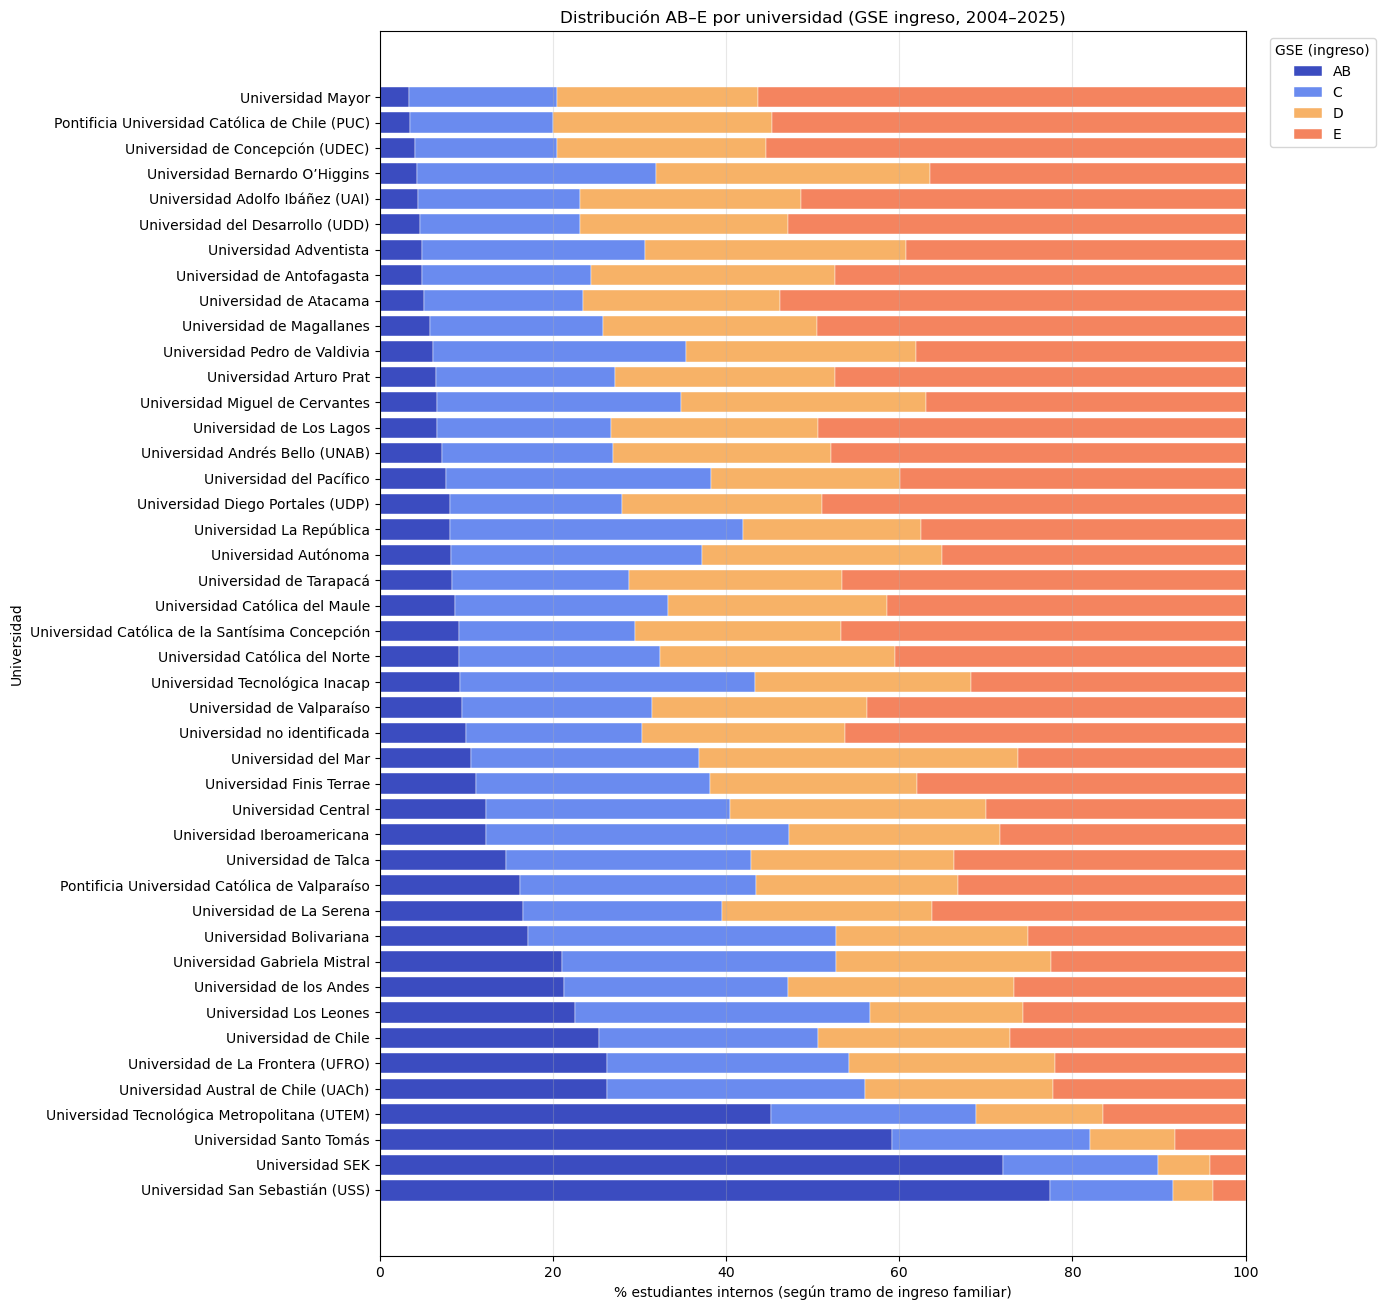

In [ ]:
# GRÁFICO FINAL
tabla_plot = tabla_pct.copy()
if "AB" in tabla_plot.columns:
    tabla_plot = tabla_plot.sort_values("AB", ascending=False)

colors = {
    "AB": "#3b4cc0",
    "C":  "#6a8bef",
    "D":  "#f7b267",
    "E":  "#f4845f",
}

fig_h = max(6, min(0.3 * len(tabla_plot), 30))
fig, ax = plt.subplots(figsize=(14, fig_h))

left = np.zeros(len(tabla_plot))
y_labels = tabla_plot.index.astype(str)

for c in cols:
    ax.barh(
        y_labels,
        tabla_plot[c].values,
        left=left,
        label=c,
        color=colors.get(c, "#999999"),
        edgecolor="white",
        linewidth=0.3
    )    
    left += tabla_plot[c].values

ax.set_xlabel("% estudiantes internos (según tramo de ingreso familiar)")
ax.set_ylabel("Universidad")
ax.set_title("Distribución AB–E por universidad (GSE ingreso, 2004–2025)")
ax.set_xlim(0, 100)
ax.legend(title="GSE (ingreso)", bbox_to_anchor=(1.02, 1), loc="upper left")
ax.grid(axis="x", alpha=0.3)
plt.tight_layout()
ruta = os.path.join("graficos-imagenes")
plt.savefig(os.path.join(ruta, 'pregunta3.png')) # guardamos el grafico en su carpeta correspondiente
plt.show()
